# Выявление определяющих успешность игры закономерностей

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.



# Описание данных

    Name — название игры
    Platform — платформа
    Year_of_Release — год выпуска
    Genre — жанр игры
    NA_sales — продажи в Северной Америке (миллионы проданных копий)
    EU_sales — продажи в Европе (миллионы проданных копий)
    JP_sales — продажи в Японии (миллионы проданных копий)
    Other_sales — продажи в других странах (миллионы проданных копий)
    Critic_Score — оценка критиков (максимум 100)
    User_Score — оценка пользователей (максимум 10)
    Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as st
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Первичный анализ данных

In [49]:
df = pd.read_csv('/datasets/games.csv')

In [50]:
df.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [51]:
df.columns = ['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating']

In [52]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year_of_release,16446.0,2006.484616,5.877050,1980.0,2003.0,2007.00,2010.00,2016.00
na_sales,16715.0,0.263377,0.813604,0.0,0.0,0.08,0.24,41.36
eu_sales,16715.0,0.145060,0.503339,0.0,0.0,0.02,0.11,28.96
jp_sales,16715.0,0.077617,0.308853,0.0,0.0,0.00,0.04,10.22
other_sales,16715.0,0.047342,0.186731,0.0,0.0,0.01,0.03,10.57
critic_score,8137.0,68.967679,13.938165,13.0,60.0,71.00,79.00,98.00


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


# Подготовка данных

## Удаление и приведение типов

Удалим две записи из таблицы, которые не имеют ни имени, ни жанра. Для нас такие данные не представляют интереса.

In [54]:
df[(df['name'].isna()) & (df['genre'].isna())]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [55]:
df.drop(df[(df['name'].isna()) & (df['genre'].isna())].index, inplace=True)

Тип user_score меняем с object на float64 с параметром 'coerce' (заполняется NaN в случае ошибки).

In [56]:
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')

Critic_score имееть только целочисленные значения, можно изменить на int8.

In [57]:
df['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 35., 41., 36., 28., 31., 27., 26., 19., 23.,
       24., 21., 17., 22., 13.])

In [58]:
df['critic_score'] = pd.to_numeric(df['critic_score'], downcast='integer', errors='coerce')

In [59]:
df['critic_score']

0        76.0
1         NaN
2        82.0
3        80.0
4         NaN
         ... 
16710     NaN
16711     NaN
16712     NaN
16713     NaN
16714     NaN
Name: critic_score, Length: 16713, dtype: float64

Прниято решение не заполнять пропуски 'critic_score', 'user_score' и 'year_of_release', чтобы не засорять данные нулевыми незначащими цифрами.

Приводим rating к удобочитаемому виду. Пропуски и редки значения заменяем на 'No rating'.

In [60]:
df['rating'].value_counts()

E       3990
T       2961
M       1563
E10+    1420
EC         8
RP         3
K-A        3
AO         1
Name: rating, dtype: int64

In [61]:
rating_dict = {
    'E': 'Everyone',
    'E10+': 'Everyone',
    'T': 'Teen',
    'M': 'Mature',
    'AO': 'Mature'
}

def rating_change(row):
    if row['rating'] in rating_dict:
        return rating_dict[row['rating']]
    return 'No rating'

In [62]:
df['rating'] = df.apply(rating_change, axis=1)

Посчитаем суммарные продажи во всех регионах и запишите их в отдельный столбец.

In [63]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16444 non-null float64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       8137 non-null float64
user_score         7590 non-null float64
rating             16713 non-null object
total_sales        16713 non-null float64
dtypes: float64(8), object(4)
memory usage: 1.7+ MB


## Убираем выбросы в данных

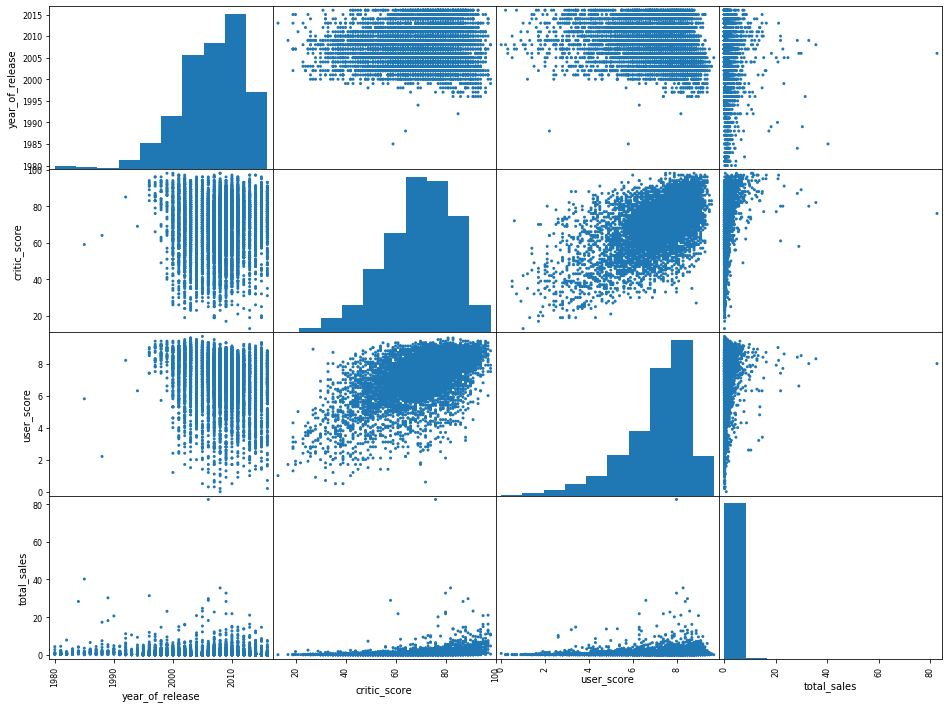

In [65]:
pd.plotting.scatter_matrix(df.loc[:, ['platform', 'year_of_release', 'genre', 'critic_score', 
                                  'user_score', 'rating', 'total_sales']], figsize=(16, 12), alpha=1)
plt.show()

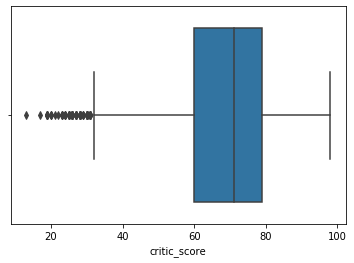

In [66]:
sns.boxplot(df['critic_score'])

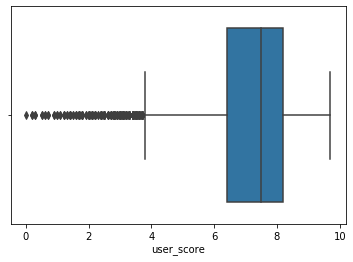

In [67]:
sns.boxplot(df['user_score'])

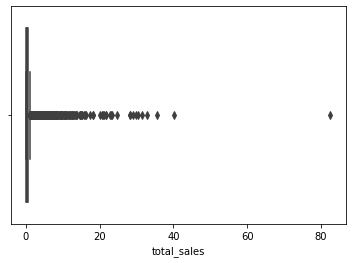

In [68]:
sns.boxplot(df['total_sales'])

In [69]:
df[(df['total_sales'] < df['total_sales'].quantile(q=0.1)) | (df['total_sales'] > df['total_sales'].quantile(q=0.9))]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,Everyone,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,No rating,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,Everyone,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,Everyone,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,No rating,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,No rating,0.01
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,No rating,0.01
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,No rating,0.01
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,No rating,0.01


In [70]:
df.drop(index=df[(df['total_sales'] < df['total_sales'].quantile(q=0.1)) | (df['total_sales'] > df['total_sales'].quantile(q=0.9))].index, inplace=True)

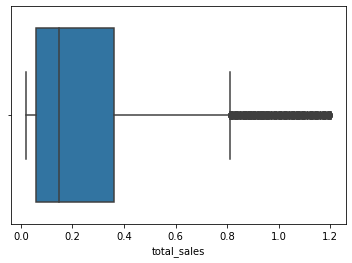

In [71]:
sns.boxplot(df['total_sales'])

Выбросов всё равно осталось достаточно много, но это связано с сильным повышением бюджета и интереса к играм в последнее время.

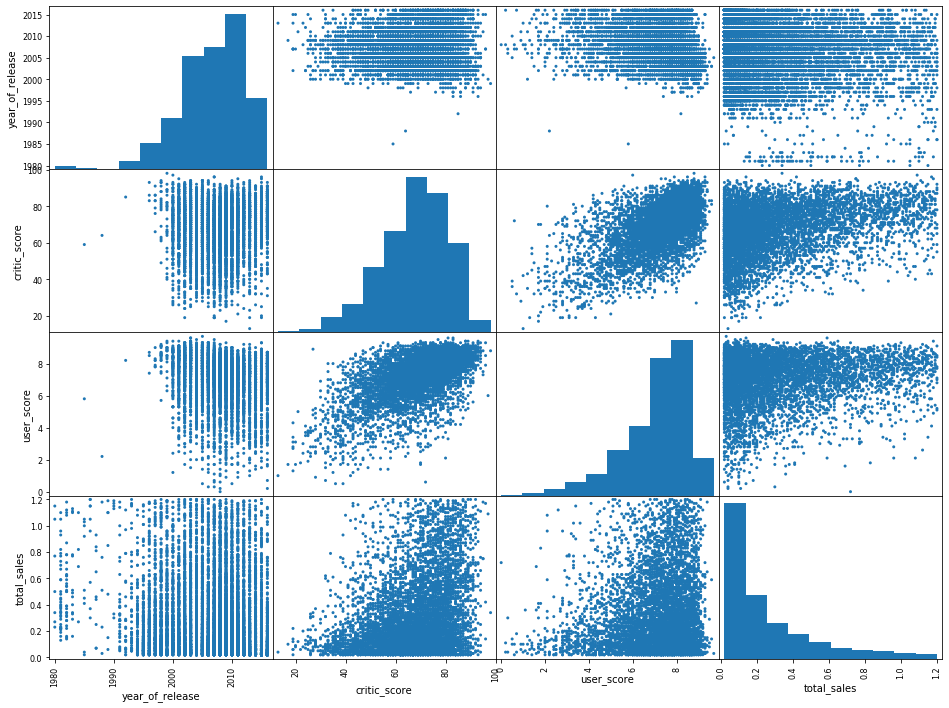

In [72]:
pd.plotting.scatter_matrix(df.loc[:, ['platform', 'year_of_release', 'genre', 'critic_score', 
                                  'user_score', 'rating', 'total_sales']], figsize=(16, 12), alpha=1)
plt.show()

# Исследовательский анализ данных

### Сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

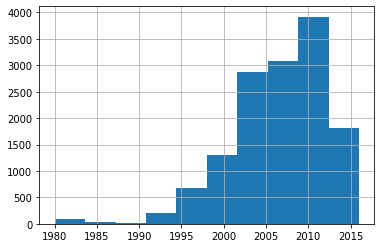

In [73]:
df['year_of_release'].hist();

Так как эта отрасль очень быстрорастущая, важны только данные за ближайшее время.

In [74]:
df.dropna(subset=['year_of_release'], inplace=True)

In [75]:
# df.drop(index=df[df['year_of_release'] < 2000].index, inplace=True)

In [76]:
df['year_of_release'] = pd.to_numeric(df['year_of_release'], downcast='integer', errors='coerce')

### Посмотрите, как менялись продажи по платформам

Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

In [77]:
top5_platform = df.pivot_table(index='platform', values='total_sales', aggfunc='sum', fill_value=0).sort_values('total_sales', ascending=False).head(5)

In [78]:
top5_platform_sales = df.loc[df['platform'].isin(top5_platform.index)].pivot_table(index='platform', columns='year_of_release', values='total_sales', aggfunc='sum', fill_value=0)

График топ 5 платформ с наибольшими суммарными продажами

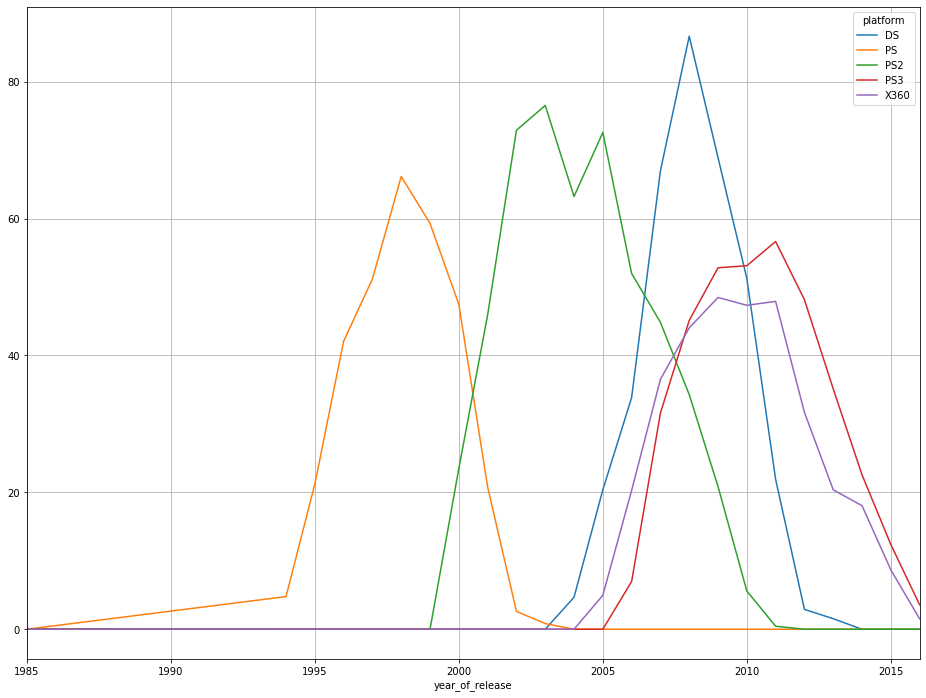

In [79]:
top5_platform_sales.T.plot(grid=True, figsize=(16, 12));

График всех платформ

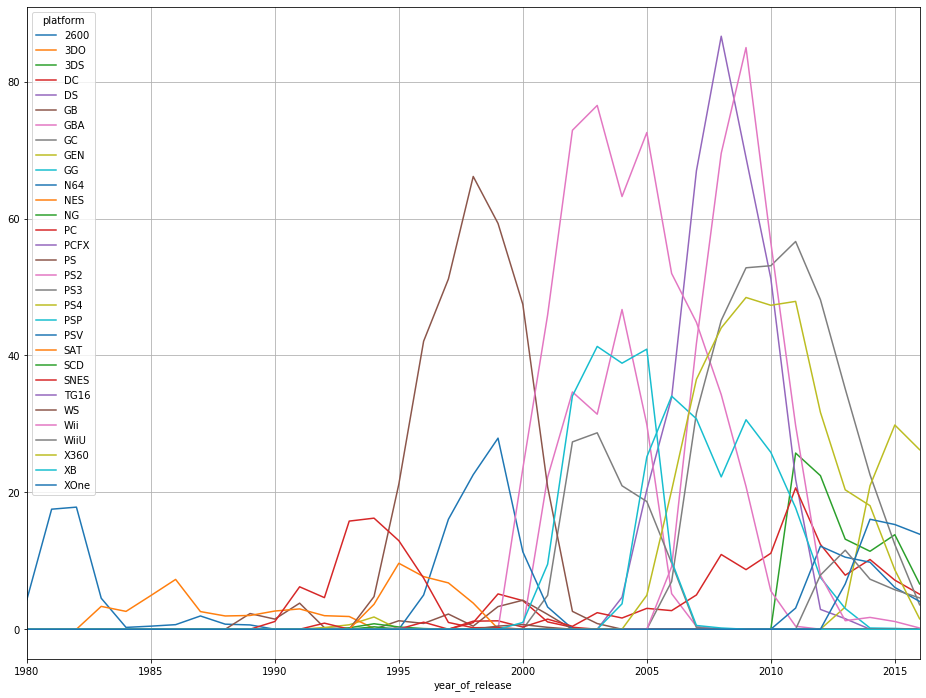

In [80]:
df.pivot_table(index='platform', columns='year_of_release', values='total_sales', aggfunc='sum', fill_value=0).T.plot(grid=True, figsize=(16, 12));

In [81]:
pivot_years = df.pivot_table(index='platform', columns='year_of_release', values='total_sales', aggfunc='sum', fill_value=0)
pivot_years = pivot_years.reset_index()

In [82]:
years = pivot_years.columns[1:].to_list()

In [83]:
def count_years_in_action(row):
    counter = 0
    for year in years:
        if row[year] != 0:
            counter += 1
    return counter
            

In [84]:
pivot_years['years_action'] = pivot_years.apply(count_years_in_action, axis=1)

In [85]:
pivot_years['years_action'].mean()

7.483870967741935

In [86]:
pivot_years['years_action'].median()

7.0

За 6.5 (возьмем для удобства 7) появляются новые и исчезают старые платформы.Далее будем работать только с данными не позднее 2010 года.

In [87]:
df.drop(index=df[df['year_of_release'] < 2012].index, inplace=True)

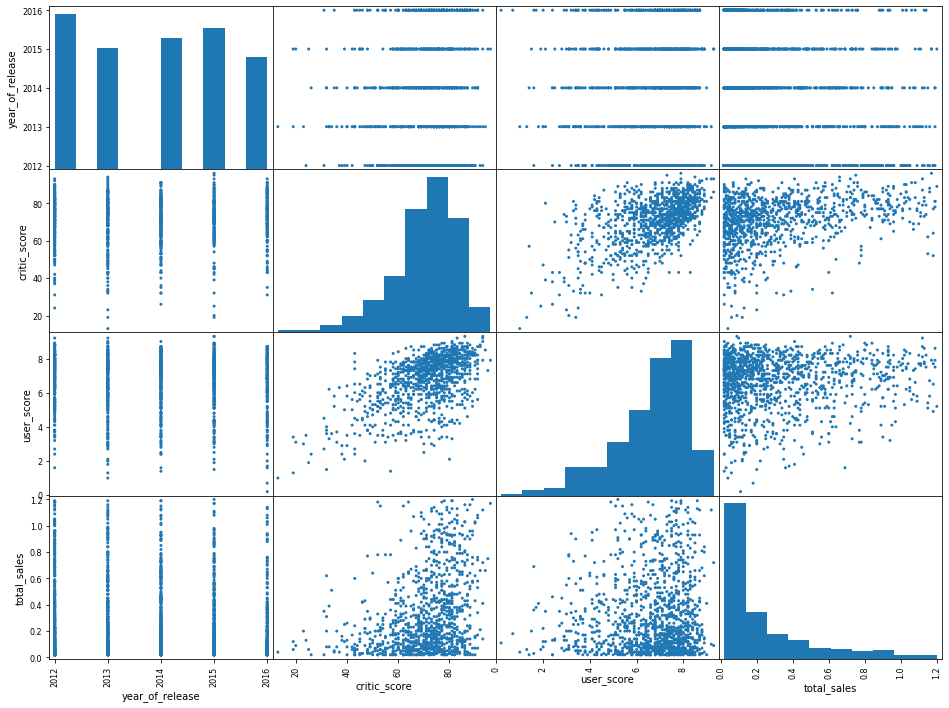

In [88]:
pd.plotting.scatter_matrix(df.loc[:, ['platform', 'year_of_release', 'genre', 'critic_score', 
                                  'user_score', 'rating', 'total_sales']], figsize=(16, 12), alpha=1)
plt.show()

### Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ

У каких платформ есть продажи на 2016 год

In [89]:
platform2016 = pivot_years[pivot_years[2016] != 0]['platform'].to_list()
platform2016

['3DS', 'PC', 'PS3', 'PS4', 'PSV', 'Wii', 'WiiU', 'X360', 'XOne']

Топ-5 самых популярных в 2016 году по продажам

In [90]:
top5platform2016 = df[df['platform'].isin(platform2016)].pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values('total_sales', ascending=False).head(5).index.to_list()
top5platform2016

['PS3', 'X360', 'PS4', '3DS', 'XOne']

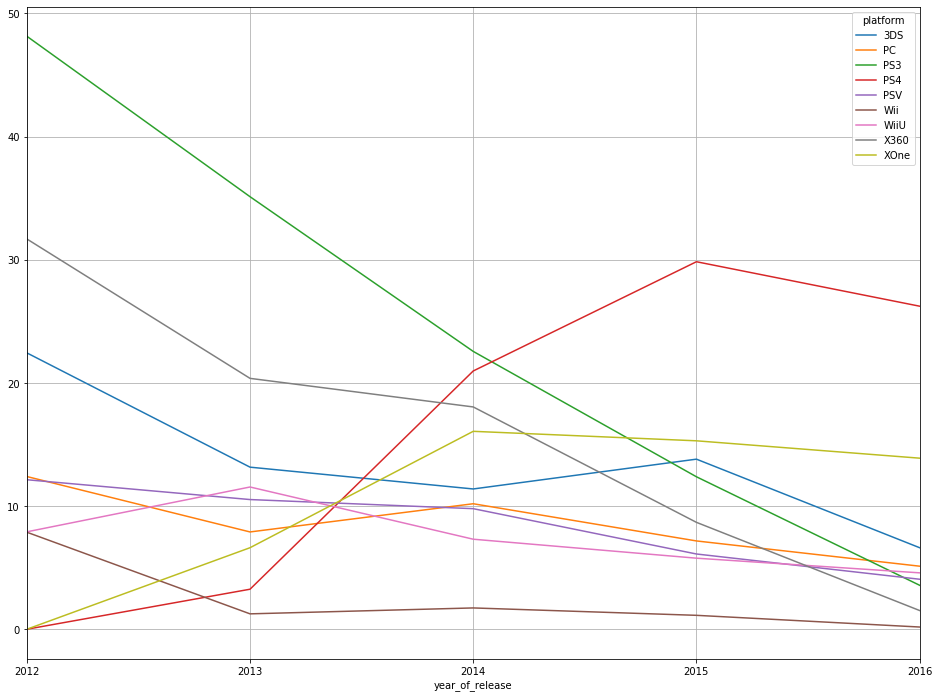

In [91]:
df[df['platform'].isin(platform2016)].pivot_table(index='platform', columns='year_of_release', values='total_sales', aggfunc='sum', fill_value=0).T.plot(xticks=[2012, 2013, 2014, 2015, 2016], grid=True, figsize=(16, 12));

Основываемся на данные за 2014-2015, тк в задании указано, что данные за 2016 год могут быть неполными.
Выбераем несколько потенциально прибыльных платформ.
- PS4 - показывает бурный рост.
- 3DS - на конец 2015 года выбивается на второе место. Отличная перспективная платформа.
- XOne - отличный конкурент у PS4.
- PS3 - всё еще хоорший претендент, но сильно сдает позиции, из за появления более новой версии консоли.
- X360 - аналогично предыдущему.

### Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам

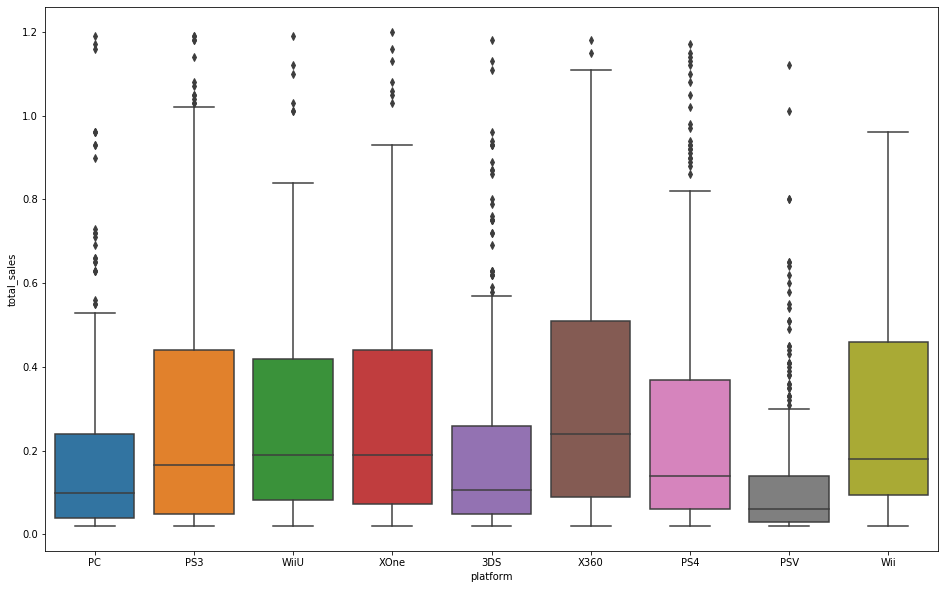

In [92]:
plt.figure(figsize=(16, 10))
sns.boxplot(x=df[df['platform'].isin(platform2016)][['platform', 'total_sales']].platform, y=df[df['platform'].isin(platform2016)][['platform', 'total_sales']].total_sales, data=df[df['platform'].isin(platform2016)][['platform', 'total_sales']])

Видно как падают продажи у PC в связи с тем, что инициативу перехватывает консольный гейминг.
PSV имеет самый низкий показатель продаж (0.06 млн. продаж).

Средние значения продаж основных платформ

In [93]:
df[df['platform'].isin(platform2016)][['platform', 'total_sales']].pivot_table(index='platform', values='total_sales', aggfunc='median').sort_values('total_sales', ascending=False)

,total_sales
platform,
X360,0.240
WiiU,0.190
XOne,0.190
Wii,0.180
PS3,0.165
PS4,0.140
3DS,0.105
PC,0.100
PSV,0.060


### Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков

In [94]:
df_ps3 = df[df['platform'] == 'PS3']

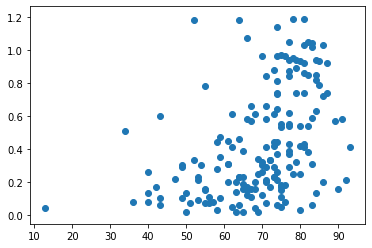

In [95]:
plt.scatter(df_ps3['critic_score'], df_ps3['total_sales'])

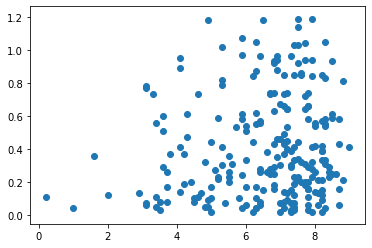

In [96]:
plt.scatter(df_ps3['user_score'], df_ps3['total_sales'])

In [97]:
df_ps3[['critic_score', 'user_score', 'total_sales']].corr()

,critic_score,user_score,total_sales
critic_score,1.000000,0.599091,0.428862
user_score,0.599091,1.000000,0.122394
total_sales,0.428862,0.122394,1.000000


In [98]:
df_x360 = df[df['platform'] == 'X360']

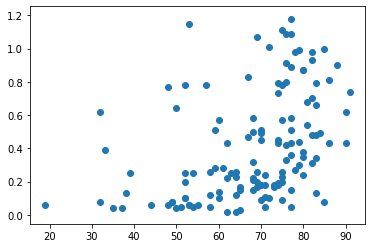

In [99]:
plt.scatter(df_x360['critic_score'], df_x360['total_sales'])

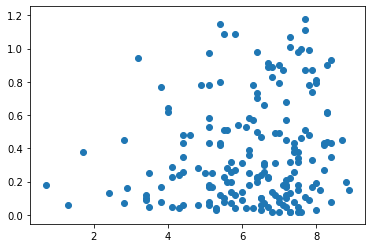

In [100]:
plt.scatter(df_x360['user_score'], df_x360['total_sales'])

In [101]:
df_x360[['critic_score', 'user_score', 'total_sales']].corr()

,critic_score,user_score,total_sales
critic_score,1.000000,0.607286,0.407141
user_score,0.607286,1.000000,0.170391
total_sales,0.407141,0.170391,1.000000


Есть средняя корреляция между total_sales и critic_score. Покупатели прислушиваются к мнению критиков.
Почти нет зависимости между total_sales и user_score. Пользователи предпочитают доверять критикам или себе, а не другим пользователям.

### Соотнесите выводы с продажами игр на других платформах

In [102]:
df.groupby(by='platform')[['critic_score', 'user_score', 'total_sales']].corr()

critic_score  user_score  total_sales
platform                                                    
3DS      critic_score      1.000000    0.692885     0.320205
         user_score        0.692885    1.000000     0.120694
         total_sales       0.320205    0.120694     1.000000
DS       critic_score           NaN         NaN          NaN
         user_score             NaN    1.000000     0.882709
         total_sales            NaN    0.882709     1.000000
PC       critic_score      1.000000    0.477966     0.338237
         user_score        0.477966    1.000000     0.071230
         total_sales       0.338237    0.071230     1.000000
PS3      critic_score      1.000000    0.599091     0.428862
         user_score        0.599091    1.000000     0.122394
         total_sales       0.428862    0.122394     1.000000
PS4      critic_score      1.000000    0.625101     0.291242
         user_score        0.625101    1.000000     0.000722
         total_sales       0.291242    0.000722     1.000000
PSP      critic_score           NaN         NaN          NaN
         user_score             NaN    1.000000    -0.802302
         total_sales            NaN   -0.802302     1.000000
PSV      critic_score      1.000000    0.673952     0.292429
         user_score        0.673952    1.000000     0.052033
         total_sales       0.292429    0.052033     1.000000
Wii      critic_score      1.000000    1.000000     1.000000
         user_score        1.000000    1.000000     0.199428
         total_sales       1.000000    0.199428     1.000000
WiiU     critic_score      1.000000    0.742136     0.447084
         user_score        0.742136    1.000000     0.447730
         total_sales       0.447084    0.447730     1.000000
X360     critic_score      1.000000    0.607286     0.407141
         user_score        0.607286    1.000000     0.170391
         total_sales       0.407141    0.170391     1.000000
XOne     critic_score      1.000000    0.549063     0.408166
         user_score        0.549063    1.000000     0.007372
         total_sales       0.408166    0.007372     1.000000

Клиенты больше реагируют на critic_score, чем на user_score.

### Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах?

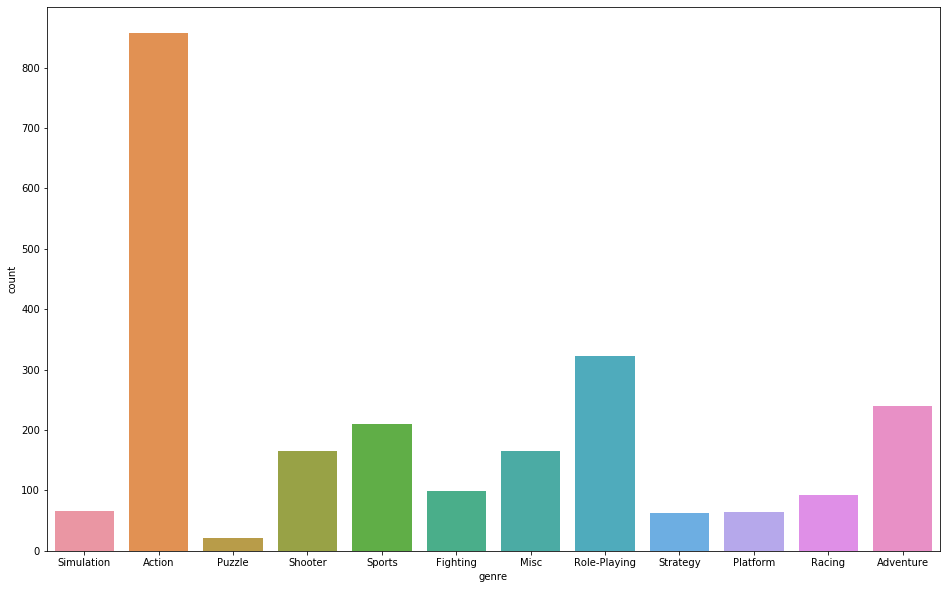

In [103]:
plt.figure(figsize=(16, 10))
sns.countplot(df['genre'])

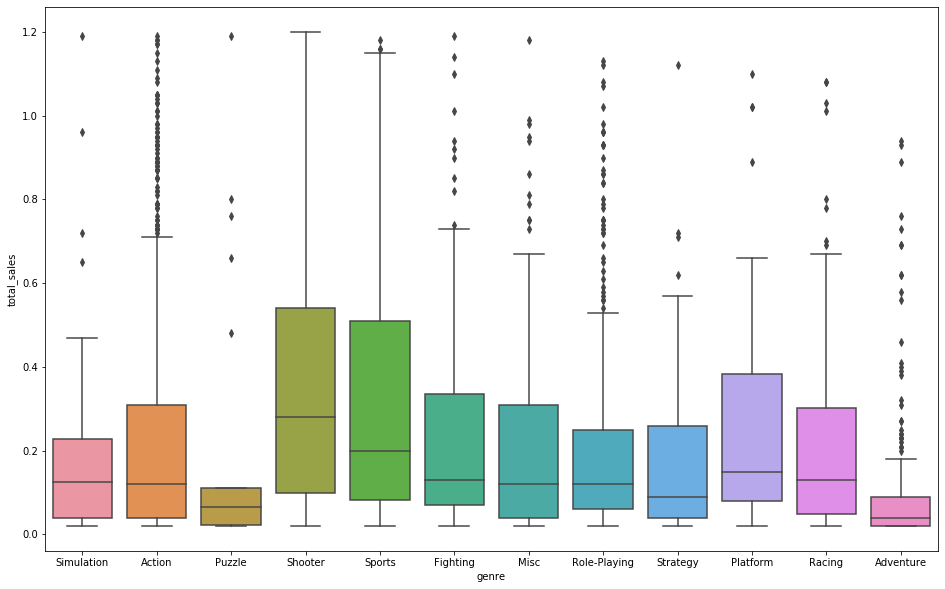

In [104]:
plt.figure(figsize=(16, 10))
sns.boxplot(x=df[['genre', 'total_sales']].genre, y=df[['genre', 'total_sales']].total_sales, data=df)

In [105]:
df.pivot_table(index='genre', values='total_sales', aggfunc='median').sort_values('total_sales', ascending=False)

,total_sales
genre,
Shooter,0.280
Sports,0.200
Platform,0.150
Fighting,0.130
Racing,0.130
Simulation,0.125
Action,0.120
Misc,0.120
Role-Playing,0.120


Shooter, Racing и Sports имеют наилучшие продажи.
Strategy, Puzzle и Adventure - самые низкие продажи.

# Портрет пользователя каждого региона

## Определите для пользователя каждого региона (NA, EU, JP)

### Самые популярные жанры (топ-5)

In [106]:
df_by_genre = df.pivot_table(index='genre', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')
df_by_genre = df_by_genre.reset_index()
df_by_genre['eu_sales_p'] = df_by_genre['eu_sales'] / df_by_genre['eu_sales'].sum() * 100
df_by_genre['jp_sales_p'] = df_by_genre['jp_sales'] / df_by_genre['jp_sales'].sum() * 100
df_by_genre['na_sales_p'] = df_by_genre['na_sales'] / df_by_genre['na_sales'].sum() * 100

In [124]:
df_by_genre[['genre', 'eu_sales_p']].sort_values('eu_sales_p', ascending=False).head(5)

,genre,eu_sales_p
0,Action,35.796115
10,Sports,12.900548
8,Shooter,12.856273
7,Role-Playing,8.168687
6,Racing,6.729758


In [125]:
df_by_genre[['genre', 'jp_sales_p']].sort_values('jp_sales_p', ascending=False).head(5)

,genre,jp_sales_p
0,Action,34.822675
7,Role-Playing,27.878619
3,Misc,8.256539
1,Adventure,7.083682
10,Sports,6.385553


In [126]:
df_by_genre[['genre', 'na_sales_p']].sort_values('na_sales_p', ascending=False).head(5)

,genre,na_sales_p
0,Action,37.175820
10,Sports,14.983791
8,Shooter,12.023265
7,Role-Playing,10.087719
3,Misc,7.179634


Action - самый популярный жанр во всех регионах;
Sports, Misc - занимают топ-5 во всех регионах на разных местах.
Топ жанров немного разнится от региона к региону в зависимости от предпочтений пользователей.

### Самые популярные платформы (топ-5). Опишите различия в долях продаж

In [139]:
df_by_platform = df.pivot_table(index='platform', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')
df_by_platform = df_by_platform.reset_index()

top5eu_sum = df_by_platform[['platform', 'eu_sales']].sort_values('eu_sales', ascending=False).head(5)['eu_sales'].sum()
top5jp_sum = df_by_platform[['platform', 'jp_sales']].sort_values('jp_sales', ascending=False).head(5)['jp_sales'].sum()
top5na_sum = df_by_platform[['platform', 'na_sales']].sort_values('na_sales', ascending=False).head(5)['na_sales'].sum()

df_by_platform['eu_sales_p'] = df_by_platform['eu_sales'] / top5eu_sum * 100
df_by_platform['jp_sales_p'] = df_by_platform['jp_sales'] / top5jp_sum * 100
df_by_platform['na_sales_p'] = df_by_platform['na_sales'] / top5na_sum * 100

In [140]:
df_by_platform

,platform,eu_sales,jp_sales,na_sales,eu_sales_p,jp_sales_p,na_sales_p
0,3DS,13.13,34.58,17.04,9.393332,34.879968,10.278063
1,DS,1.78,0.56,1.80,1.273430,0.564858,1.085711
2,PC,28.00,0.00,11.01,20.031478,0.000000,6.640931
3,PS3,36.13,26.14,44.11,25.847761,26.366754,26.605947
4,PS4,32.95,8.72,26.96,23.572757,8.795643,16.261536
5,PSP,0.42,10.17,0.13,0.300472,10.258221,0.078412
6,PSV,9.15,19.53,9.16,6.546001,19.699415,5.525062
7,Wii,4.00,2.63,4.83,2.861640,2.652814,2.913324
8,WiiU,12.43,4.23,17.64,8.892545,4.266694,10.639966
9,X360,25.35,0.81,47.20,18.135642,0.817026,28.469751


### EU топ-5 платформ по продажам в абсолютном и процентном отношении:

In [141]:
df_by_platform[['platform', 'eu_sales']].sort_values('eu_sales', ascending=False).head(5)

,platform,eu_sales
3,PS3,36.13
4,PS4,32.95
2,PC,28.00
9,X360,25.35
10,XOne,17.35


In [142]:
df_by_platform[['platform', 'eu_sales_p']].sort_values('eu_sales_p', ascending=False).head(5)

,platform,eu_sales_p
3,PS3,25.847761
4,PS4,23.572757
2,PC,20.031478
9,X360,18.135642
10,XOne,12.412362


### JP топ-5 платформ по продажам в абсолютном и процентном отношении:

In [143]:
df_by_platform[['platform', 'jp_sales']].sort_values('jp_sales', ascending=False).head(5)

,platform,jp_sales
0,3DS,34.58
3,PS3,26.14
6,PSV,19.53
5,PSP,10.17
4,PS4,8.72


In [144]:
df_by_platform[['platform', 'jp_sales_p']].sort_values('jp_sales_p', ascending=False).head(5)

,platform,jp_sales_p
0,3DS,34.879968
3,PS3,26.366754
6,PSV,19.699415
5,PSP,10.258221
4,PS4,8.795643


### NA топ-5 платформ по продажам в абсолютном и процентном отношении:

In [145]:
df_by_platform[['platform', 'na_sales']].sort_values('na_sales', ascending=False).head(5)

,platform,na_sales
9,X360,47.20
3,PS3,44.11
10,XOne,29.88
4,PS4,26.96
8,WiiU,17.64


In [146]:
df_by_platform[['platform', 'na_sales_p']].sort_values('na_sales_p', ascending=False).head(5)

,platform,na_sales_p
9,X360,28.469751
3,PS3,26.605947
10,XOne,18.022800
4,PS4,16.261536
8,WiiU,10.639966


В регионе jp пользователи больше всего покупают игры для Nintendo 3DS. В других регионах ведут борьбу за места противостощие друг другу консоли семейства PS и XBOX.

### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

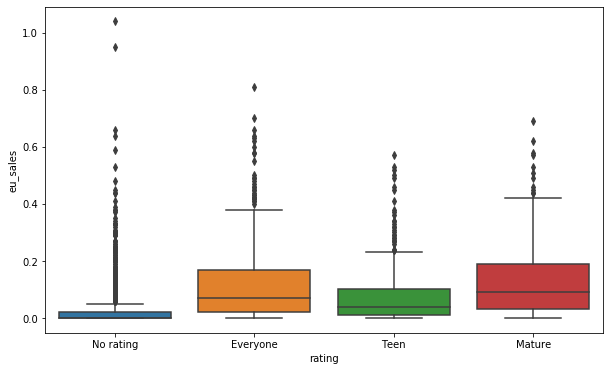

In [117]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df[['rating', 'eu_sales']].rating, y=df[['rating', 'eu_sales']].eu_sales, data=df)

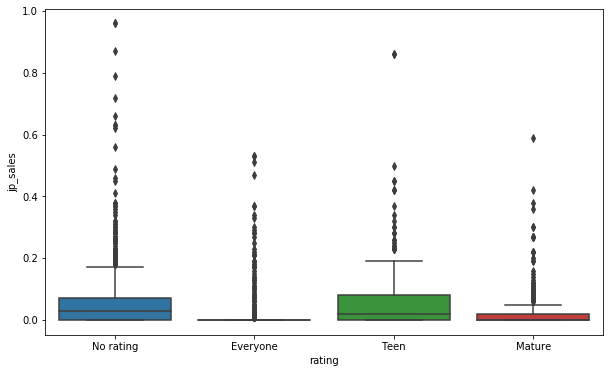

In [118]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df[['rating', 'jp_sales']].rating, y=df[['rating', 'jp_sales']].jp_sales, data=df)

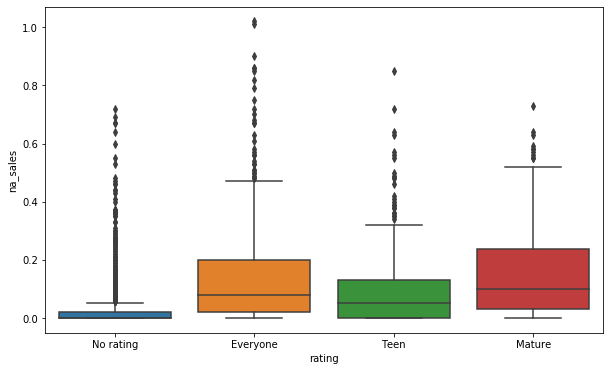

In [119]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df[['rating', 'na_sales']].rating, y=df[['rating', 'na_sales']].na_sales, data=df)

В jp регионе сильно снижены продажи у игр жанра 'Mature'.
Сильно снижены продажи во всех жанрах.

# Проверка гипотез

## Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

    Нулевая гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
    Альтернативная гипотеза: средние пользовательские рейтинги платформ Xbox One и PC различается.

In [148]:
fir = df[df['platform'] == 'XOne']['user_score'].dropna().to_list()

sec = df[df['platform'] == 'PC']['user_score'].dropna().to_list()

alpha = 0.05

results = st.ttest_ind(fir, sec)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.9816486019371776
Не получилось отвергнуть нулевую гипотезу


Гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC различается отвергнуть не получилось.

## Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные

    Нулевая гипотеза: средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») одинаковые.
    Альтернативная гипотеза: средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») различается.

In [121]:
fir = df[df['genre'] == 'Action']['user_score'].dropna().to_list()

sec = df[df['genre'] == 'Sports']['user_score'].dropna().to_list()

alpha = 0.05

results = st.ttest_ind(fir, sec)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  5.794313048592978e-20
Отвергаем нулевую гипотезу


Гипотезу о том, что средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») различается отвергнуть не получилось.

    Формировал гипотезы на основе "Гипотезы о равенстве средних двух генеральных совокупностей". Нулевая гипотеза предпологала равенство двух сравниваемых компонентов, а альтернативная напротив - неравенство.
    Использовал гипотезу alpha = 0.05 - критический уровень статистической значимости, если p-value окажется меньше него - отвергнем гипотезу


# Вывод

1.	Был проведен первичный анализ данных и подготовка данных для дальнейшей работы с ними.
Были удалены пустые записи в данных и приведены типы данных к нужным.
Был проведен анализ и приведение rating к более удобному для работы виду.
Выбросы данных проанализированы scatter_matrix и boxplot. Все выбросы были удалены.
2.	Проведен графический анализ данных по играм, выпущенным в разные года. Были отброшены устаревшие данные.
Выведен средний период жизни платформы – 7 лет.
3.	Выделены лидирующее платформы по продажам 'PS3', 'X360', 'Wii', '3DS', 'PS4'.
4.	Основываемся на данные за 2014-2015, тк в задании указано, что данные за 2016 год могут быть неполными. Выбираем несколько потенциально прибыльных платформ.
PS4 - показывает бурный рост.
3DS - на конец 2015 года выбивается на второе место. Отличная перспективная платформа.
XOne - отличный конкурент у PS4.
PS3 - всё еще хороший претендент, но сильно сдает позиции, из за появления более новой версии консоли.
X360 - аналогично предыдущему.
5.	Проведен анализ влияния рейтингов критиков и игроков на успешность продаж с помощью корреляции Пирсона. Сделан вывод, что критики в гораздо большей мере влияют на показатель продаж, чем игроки.
6.	Самые популярные игры по жанрам: action, misc, adventure, role-playing.
7.	Shooter, Racing и Sports имеют наилучшие продажи. Strategy, Puzzle и Adventure - самые низкие продажи.
8.	Action - самый популярный жанр во всех регионах; Sports, Misc - занимают топ-5 во всех регионах на разных местах. Топ жанров немного разнится от региона к региону в зависимости от предпочтений пользователей. В регионе jp пользователи больше всего покупают игры для Nintendo 3DS. В других регионах ведут борьбу за места противостоящие друг другу консоли семейства PS и XBOX.
9.	В jp регионе сильно снижены продажи у игр жанра 'Mature'. Сильно снижены продажи во всех жанрах.
10.	Были выдвинуты и проверены определенные гипотезы, результаты исследования и выводы приведены выше.
